In [52]:
# !pip install --upgrade scikit-learn

### 1. Imports des modules

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from statistics import mean 

from datetime import datetime
import ast

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate

#CLASSIFIEURS
from sklearn import discriminant_analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#CLUSTERING
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from tqdm import tqdm_notebook as tqdm 


### 2. Lecture des données

In [13]:
parse_dates = ['DATE']
glasses_df = pd.read_csv("./donnees/glasses.csv", parse_dates= parse_dates)
parse_dates = ['timestamp']
smartwatch_df = pd.read_csv("./donnees/smartwatch.csv", parse_dates= parse_dates)
smartphone_df = pd.read_csv("./donnees/smartphone.csv", parse_dates= parse_dates)
parse_dates = ['to', 'from']
report_df = pd.read_csv("./donnees/report.csv", parse_dates= parse_dates)

In [14]:
smartphone_df[smartphone_df['source']=='proximity'].head()

,index,source,timestamp,values
37,1316865,proximity,2017-06-29 07:45:28.087,['0.0']
35895,1352842,proximity,2017-06-29 10:34:19.822,['5.0']
35916,1352863,proximity,2017-06-29 10:34:26.056,['0.0']
47237,1364252,proximity,2017-06-29 11:36:50.970,['5.0']
47283,1364298,proximity,2017-06-29 11:37:02.588,['0.0']


In [15]:
list(smartphone_df.source.unique())

['step_detector',
 'battery',
 'activity',
 'audio',
 'orientation',
 'accelerometer',
 'gyroscope',
 'magnetometer',
 'pressure',
 'light',
 'gravity',
 'linear_acceleration',
 'rotationVector',
 'wifi',
 'proximity',
 'bluetooth',
 'step_counter']

In [20]:
data = {}

# data['activity'] = [None] * len(smartphone_df)

data['light'] = [None] * len(smartphone_df)
data['audio'] = [None] * len(smartphone_df)
data['steps'] = [None] * len(smartphone_df)
data['wifi'] = [None] * len(smartphone_df)
data['bluetooth'] = [None] * len(smartphone_df)
data['accelerometer'] = [None] * len(smartphone_df)


for index, row in tqdm(smartphone_df.iterrows(), total=len(smartphone_df)):
    
    if row['source'] != 'activity':
        values = [ float(x) for x in ast.literal_eval(row['values']) ]
#     else:
#         data['activity'][index] = values[0]
    
    if row['source'] == 'light':
        data['light'][index] = values[0]

    if row['source'] == 'audio':
        data['audio'][index] = mean(values)

    if row['source'] == 'step_detector':
        data['steps'][index] = values[0]
    
    if row['source'] == 'accelerometer':
        data['accelerometer'][index] = (sum([x**2 for x in values]))**0.5

    if row['source'] == 'wifi':
        data['wifi'][index] = len(values)
        
    if row['source'] == 'bluetooth':
        data['bluetooth'][index] = len(values)
        

# smartwatch_df["activity"] = data['activity']
smartphone_df["light"] = data['light']
smartphone_df["audio"] = data['audio']
smartphone_df["wifi"] = data['wifi']
smartphone_df["bluetooth"] = data['bluetooth']
smartphone_df["steps"] = data['steps']
smartphone_df["accelerometer"] = data['accelerometer']


resampling_functions = {
    'light': np.mean,
    'audio': np.mean,
    'wifi': np.mean,
    'bluetooth': np.mean,
    'steps': np.sum,
    'accelerometer': np.mean
}

smartphone_df = smartphone_df[ 
                    smartphone_df['light'].notnull() | 
                    smartphone_df['audio'].notnull() | 
                    smartphone_df['wifi'].notnull() | 
                    smartphone_df['bluetooth'].notnull() | 
                    smartphone_df['steps'].notnull() |
                    smartphone_df['accelerometer'].notnull()
                             ]

smartphone_df = smartphone_df.set_index('timestamp')
smartphone_df = smartphone_df[['light','audio','wifi','bluetooth', 'steps', 'accelerometer']]
smartphone_df = smartphone_df.resample('min').agg(resampling_functions)
smartphone_df['steps'].fillna(0.0, inplace=True)
smartphone_df = smartphone_df.dropna()
smartphone_df.head()

HBox(children=(IntProgress(value=0, max=1528218), HTML(value='')))

,light,audio,wifi,bluetooth,steps,accelerometer
timestamp,,,,,,
2017-06-29 09:14:00,2.406000,32767.0,63.666667,3.000000,0.0,9.499753
2017-06-29 09:15:00,2.140667,32767.0,63.833333,2.000000,21.0,10.430474
2017-06-29 09:24:00,2.406000,32767.0,57.000000,2.500000,117.0,13.030613
2017-06-29 09:50:00,2.406000,32767.0,72.000000,2.000000,82.0,10.196775
2017-06-29 09:51:00,0.680667,32767.0,65.200000,2.333333,116.0,14.664845


In [21]:
# smartphone_df.loc[smartphone_df['steps']<=3, 'steps'] = 0
# smartphone_df.loc[smartphone_df['steps']>3, 'steps'] = 1
# smartphone_df.head()

,light,audio,wifi,bluetooth,steps,accelerometer
timestamp,,,,,,
2017-06-29 09:14:00,2.406000,32767.0,63.666667,3.000000,0.0,9.499753
2017-06-29 09:15:00,2.140667,32767.0,63.833333,2.000000,21.0,10.430474
2017-06-29 09:24:00,2.406000,32767.0,57.000000,2.500000,117.0,13.030613
2017-06-29 09:50:00,2.406000,32767.0,72.000000,2.000000,82.0,10.196775
2017-06-29 09:51:00,0.680667,32767.0,65.200000,2.333333,116.0,14.664845
2017-06-29 09:52:00,1.203000,32767.0,57.250000,1.750000,117.0,14.426127
2017-06-29 09:53:00,1.968545,32767.0,60.000000,2.500000,81.0,12.156010
2017-06-29 09:54:00,1.683167,32767.0,55.625000,2.666667,79.0,10.159444
2017-06-29 09:55:00,0.881167,32767.0,51.555556,1.333333,96.0,14.189883


In [143]:
report_df.head()

,index,activity_type,duration,from,to,comment
0,0,Video games,01:43,2017-07-01 21:34:00,2017-07-01 23:17:00,NaN
1,1,In computer,00:03,2017-07-01 21:29:00,2017-07-01 21:32:00,NaN
2,2,At home,13:35,2017-07-01 21:13:00,2017-07-02 10:49:00,NaN
3,3,In computer,00:05,2017-07-01 21:08:00,2017-07-01 21:13:00,NaN
4,4,Eat,00:18,2017-07-01 20:49:00,2017-07-01 21:07:00,NaN


In [22]:
data = {}
data['activity_index'] = [None] * len(smartphone_df)
data['activity_type'] = [None] * len(smartphone_df)

i=0
for index, row in tqdm(smartphone_df.iterrows(), total=len(smartphone_df)):
    for report_index, report_row in report_df.iterrows():
        if (index >= report_row['from']) & (index < report_row['to']):
            data['activity_index'][i] = int(report_row['index'])
            data['activity_type'][i] = report_row['activity_type']
    i=i+1

smartphone_df["activity_index"] = data['activity_index']
smartphone_df["activity_type"] = data['activity_type']
smartphone_df = smartphone_df.dropna()
smartphone_df.head()

HBox(children=(IntProgress(value=0, max=889), HTML(value='')))

,light,audio,wifi,bluetooth,steps,accelerometer,activity_index,activity_type
timestamp,,,,,,,,
2017-06-29 09:57:00,0.534667,32767.0,47.125000,2.500000,91.0,12.654205,12.0,Eat
2017-06-29 09:58:00,2.406000,32767.0,56.750000,2.000000,53.0,10.117409,12.0,Eat
2017-06-29 09:59:00,2.406000,32767.0,55.285714,3.333333,72.0,10.429776,12.0,Eat
2017-06-29 10:00:00,0.960333,32767.0,61.000000,1.500000,96.0,10.188598,12.0,Eat
2017-06-29 10:01:00,1.282167,32767.0,60.000000,2.500000,50.0,9.982670,12.0,Eat


In [23]:
smartphone_df.describe()

,light,audio,wifi,bluetooth,steps,accelerometer,activity_index
count,435.000000,435.0,435.000000,435.000000,435.000000,435.000000,435.000000
mean,28.136581,32767.0,11.681834,1.550958,32.427586,10.335835,6.551724
std,193.419376,0.0,15.845240,0.629157,41.233528,1.700872,3.500358
min,0.000000,32767.0,0.000000,1.000000,0.000000,7.823266,0.000000
25%,0.806937,32767.0,3.527778,1.000000,0.000000,9.549836,5.000000
50%,1.705667,32767.0,5.000000,1.500000,13.000000,9.806915,6.000000
75%,2.406000,32767.0,9.693182,2.000000,50.000000,10.210497,8.500000
max,3091.949273,32767.0,109.200000,5.000000,150.000000,21.859330,18.000000


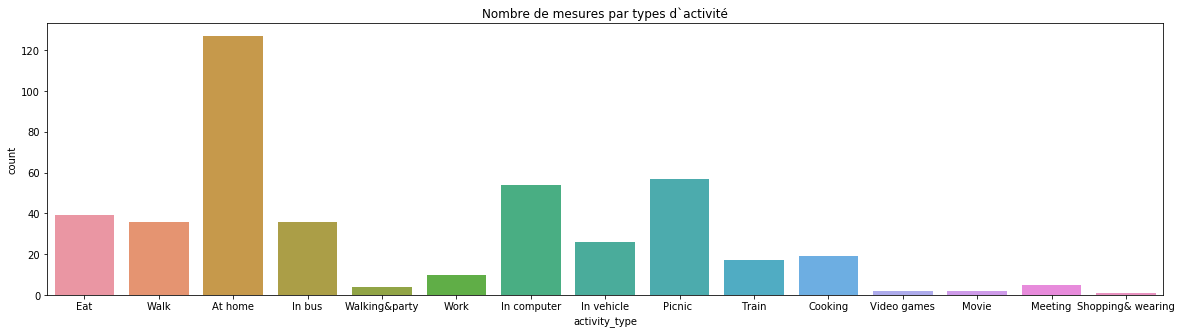

In [24]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="activity_type", data=smartphone_df).set_title('Nombre de mesures par types d`activité')

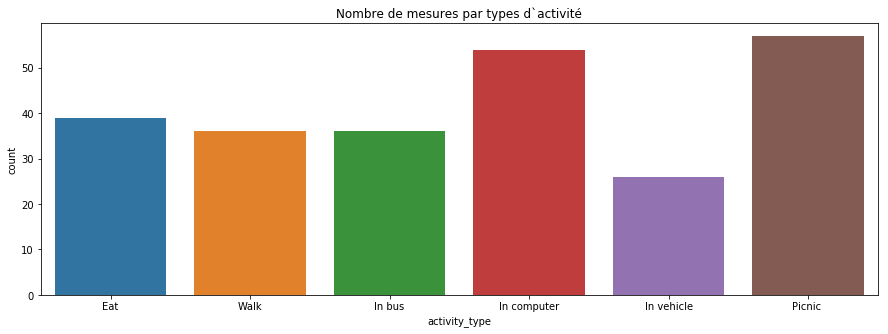

In [28]:
smartphone_df = smartphone_df.drop(smartphone_df.index[smartphone_df['activity_type'] == 'At home'], axis = 0)
smartphone_df = smartphone_df.drop(smartphone_df.index[smartphone_df['activity_type'] == 'Walking&party'], axis = 0)
for activity_type in smartphone_df['activity_type'].unique():
    if len(smartphone_df[smartphone_df['activity_type'] == activity_type])<20:
        smartphone_df = smartphone_df.drop(smartphone_df.index[smartphone_df['activity_type'] == activity_type], axis = 0)

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(x="activity_type", data=smartphone_df).set_title('Nombre de mesures par types d`activité')

In [30]:
smartphone_df.columns

Index(['light', 'audio', 'wifi', 'bluetooth', 'steps', 'accelerometer',
       'activity_index', 'activity_type'],
      dtype='object')

In [31]:
variables = [
    'light', 
    'audio', 
    'wifi', 
    'bluetooth', 
    'steps', 
    'accelerometer',
]

# Centrage reduction des donnees quantitatives
normal_scaler = preprocessing.StandardScaler()
normal_scaler_fit = normal_scaler.fit(smartphone_df[variables])
smartphone_normal = normal_scaler_fit.transform(smartphone_df[variables])

# X et Y: entrees et sorties du modele

X = pd.DataFrame(smartphone_normal, columns=variables)

y = smartphone_df['activity_type']

smartphone_df_normal = pd.DataFrame(smartphone_normal, columns=variables)
smartphone_df_normal['activity_type'] = smartphone_df['activity_type'].tolist()

In [33]:
smartphone_df_normal.head()

,light,audio,wifi,bluetooth,steps,accelerometer,activity_type
0,-0.367890,0.0,2.024565,1.868386,1.592278,2.320640,Eat
1,-0.321047,0.0,2.578353,1.021190,0.604351,0.014986,Eat
2,-0.321047,0.0,2.494103,3.280380,1.098314,0.298891,Eat
3,-0.357235,0.0,2.822883,0.173994,1.722268,0.079688,Eat
4,-0.349179,0.0,2.765346,1.868386,0.526356,-0.107476,Eat


In [35]:
smartphone_df[variables].describe()

,light,audio,wifi,bluetooth,steps,accelerometer
count,248.000000,248.0,248.000000,248.000000,248.000000,248.000000
mean,15.231606,32767.0,11.937464,1.397312,29.754032,10.100921
std,40.030035,0.0,17.415444,0.591376,38.542158,1.102475
min,0.000000,32767.0,0.000000,1.000000,0.000000,7.823266
25%,0.794686,32767.0,3.333333,1.000000,0.000000,9.529533
50%,1.604000,32767.0,4.866667,1.000000,11.000000,9.753626
75%,3.630700,32767.0,9.416667,1.750000,47.250000,10.103068
max,219.244711,32767.0,109.200000,5.000000,147.000000,17.182533


In [ ]:
    'light', 
    'audio', 
    'wifi', 
    'bluetooth', 
    'steps', 
    'accelerometer',

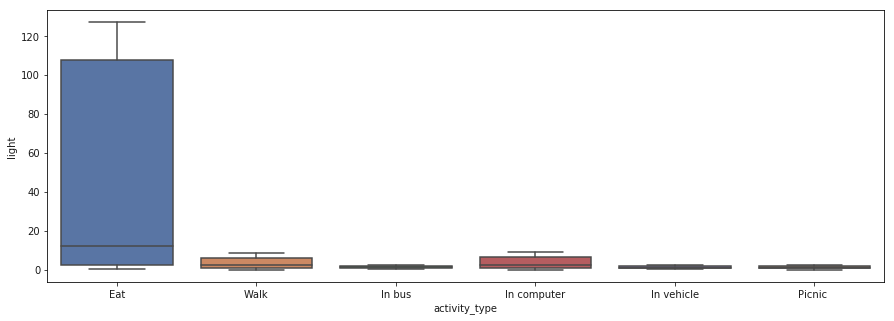

In [36]:
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="light", data=smartphone_df, showfliers=False)

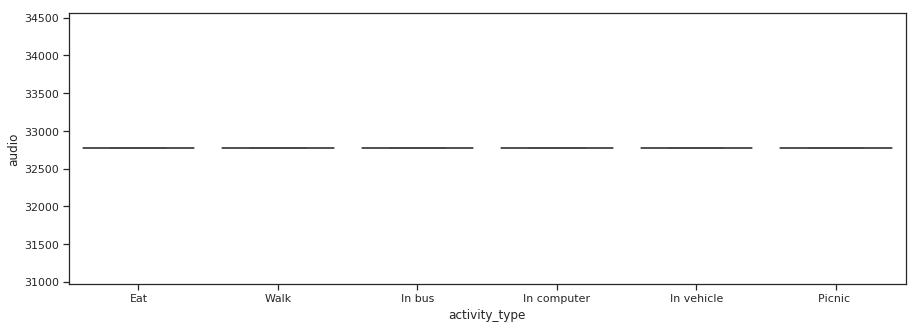

In [47]:
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="audio", data=smartphone_df, showfliers=False)

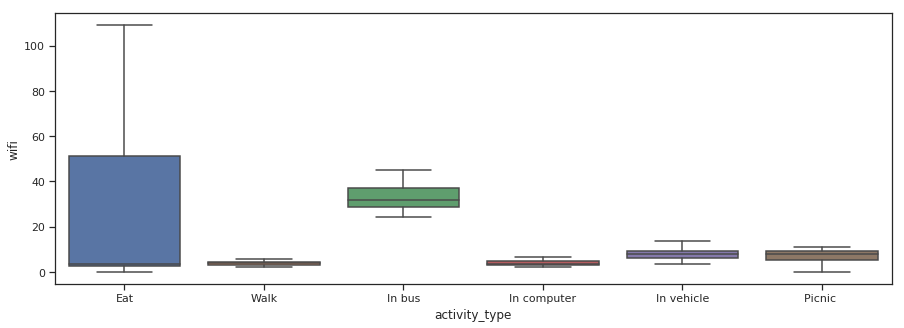

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="wifi", data=smartphone_df, showfliers=False)

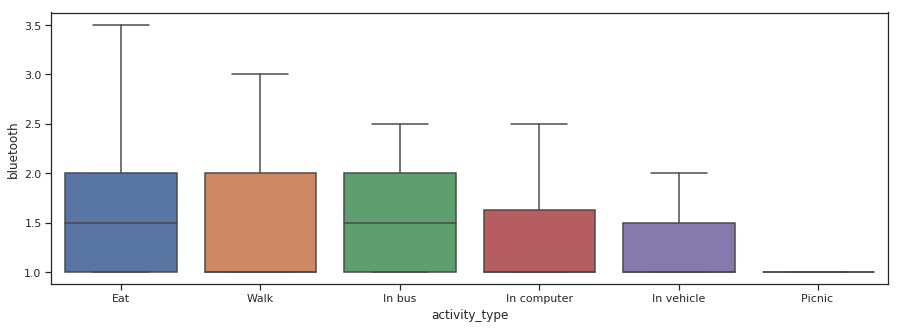

In [40]:
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="bluetooth", data=smartphone_df, showfliers=False)

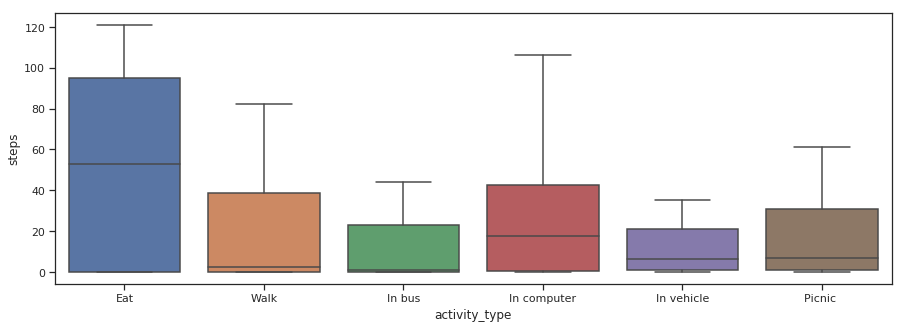

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="steps", data=smartphone_df, showfliers=False)

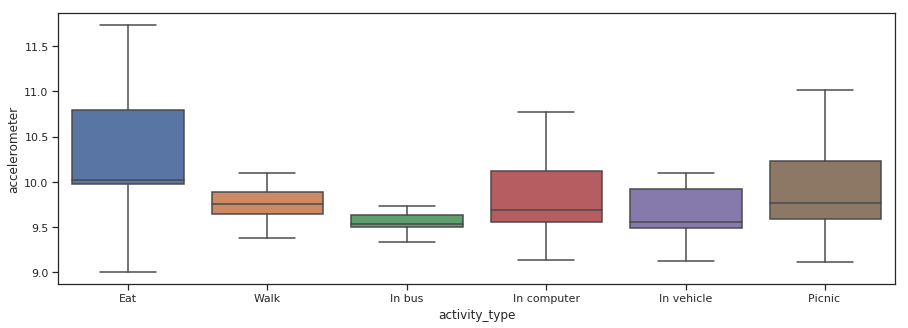

In [42]:
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="accelerometer", data=smartphone_df, showfliers=False)

### 4.  Corrélations

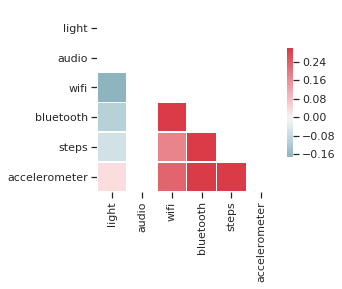

In [43]:
# Matrice de correlation
corr = X.corr()

# Pour n'afficher que la partie inferieure de la matrice
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Afficher la heatmap
f, ax = plt.subplots(figsize=(4, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 4.  Analyse par Composantes Principales

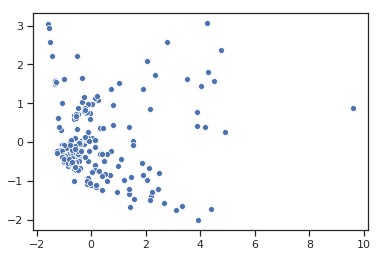

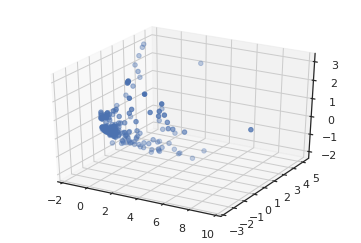

 
Explained variances:
[0.4487027106627806, 0.22276115935883864, 0.16463626479067087]
 
Sum of explained variances: 0.8361001348122901
 


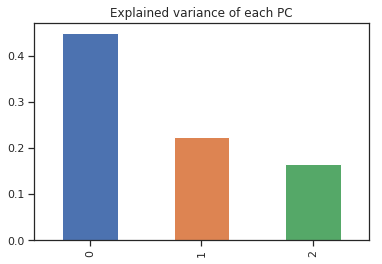

In [44]:
n_components = 3
pca = PCA(n_components = n_components)
X_pca = pca.fit_transform(X)

sns.scatterplot(X_pca[:, 0], X_pca[:, 2])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2])
plt.show()

print(' ')
print('Explained variances:')
print(pca.explained_variance_ratio_.tolist())
pd.Series(pca.explained_variance_ratio_.tolist()).plot(kind="bar", title= "Explained variance of each PC")
print(' ')
print('Sum of explained variances: ' + str(sum(pca.explained_variance_ratio_.tolist())))
print(' ')

## 5. Classification non-supervisée

### 5.1. CAH

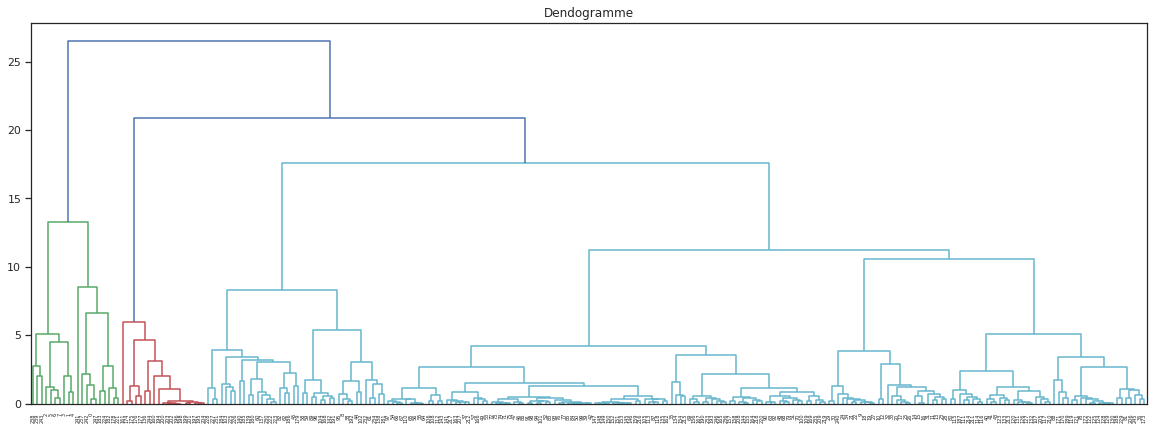

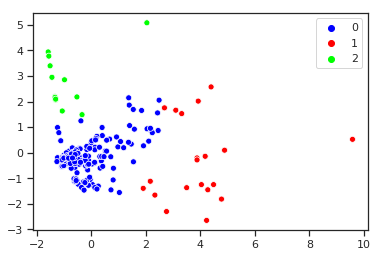

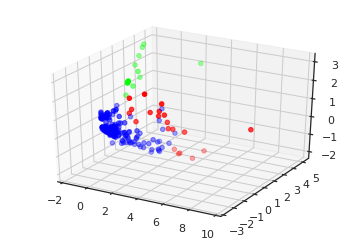

In [49]:
plt.figure(figsize=(20, 7))  
plt.title("Dendogramme")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))    

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(X) 


plt.show()
sns.scatterplot(X_pca[:, 0], X_pca[:, 1],  hue=cluster.labels_, palette = 'brg')

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2], c=cluster.labels_, cmap = 'brg') 

### 5.2. K-Means

#### 5.2.1. Sans PCA

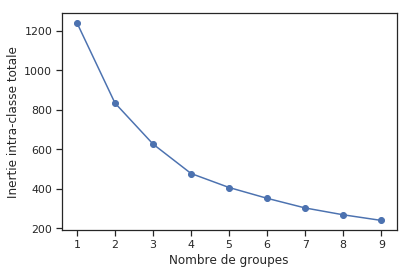

Centres des classes:
      light  audio      wifi  bluetooth     steps  accelerometer
0 -0.293035    0.0 -0.146590  -0.252874 -0.312561       -0.31308
1  3.218099    0.0 -0.495656  -0.405666 -0.532723       -0.05125
2 -0.140187    0.0  0.955628   1.429582  1.782264        1.55023


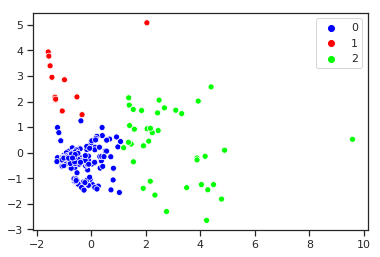

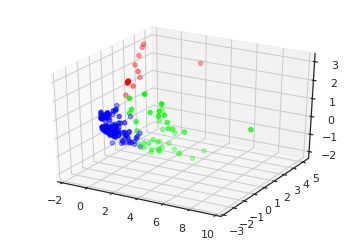

In [50]:
inerties = []
for i in range(1, 10):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X)
    inerties.append(km.inertia_)

plt.plot(range(1, 10), inerties, marker='o')
plt.xlabel('Nombre de groupes')
plt.ylabel('Inertie intra-classe totale')
plt.show()

km_n_clusters_ = 3
kmeans = KMeans(n_clusters=km_n_clusters_, random_state=0).fit(X)
km_labels = kmeans.labels_
km_n_clusters_ = len(np.unique(km_labels))
centers_km = pd.DataFrame(kmeans.cluster_centers_, columns=variables)

print('Centres des classes:')
print(centers_km)

plt.show()
sns.scatterplot(X_pca[:, 0], X_pca[:, 1],  hue=km_labels, palette = 'brg')

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2], c=km_labels, cmap = 'brg')   

#### 5.2.2. Avec PCA

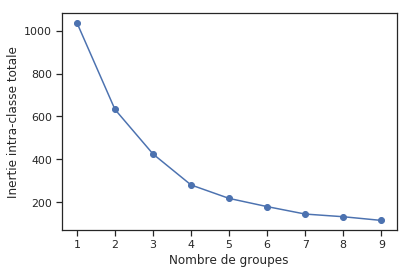

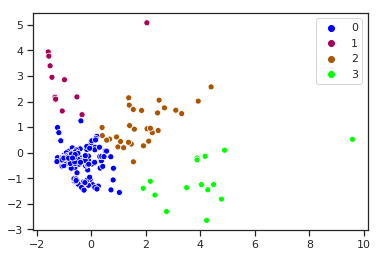

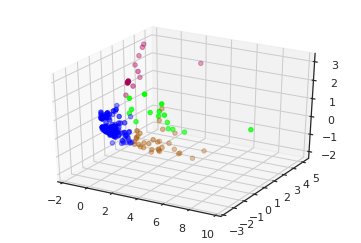

In [53]:
inerties = []
for i in range(1, 10):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X_pca)
    inerties.append(km.inertia_)

plt.plot(range(1, 10), inerties, marker='o')
plt.xlabel('Nombre de groupes')
plt.ylabel('Inertie intra-classe totale')
plt.show()

km_n_clusters_ = 4
kmeans = KMeans(n_clusters=km_n_clusters_, random_state=0).fit(X_pca)
km_labels = kmeans.labels_
km_n_clusters_ = len(np.unique(km_labels))
# centers_km = pd.DataFrame(kmeans.cluster_centers_, columns=variables)

# print('Centres des classes:')
# print(centers_km)


plt.show()
sns.scatterplot(X_pca[:, 0], X_pca[:, 1],  hue=km_labels, palette = 'brg')

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2], c=km_labels, cmap = 'brg')   


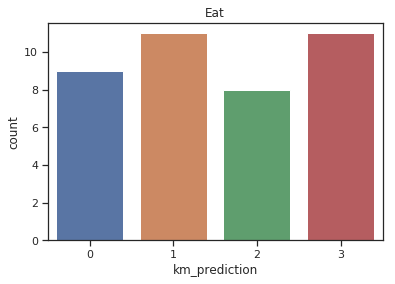

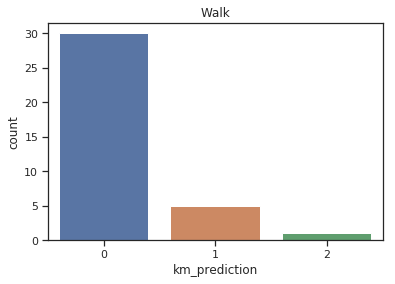

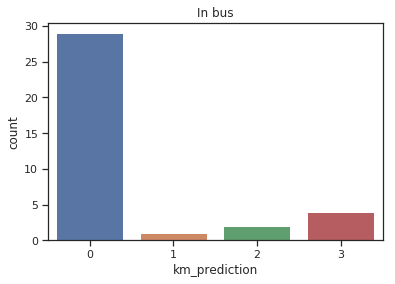

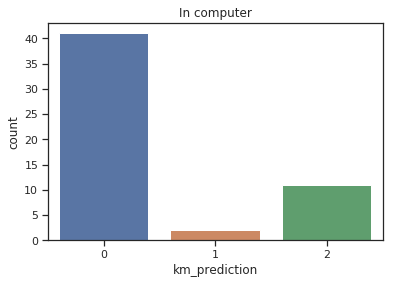

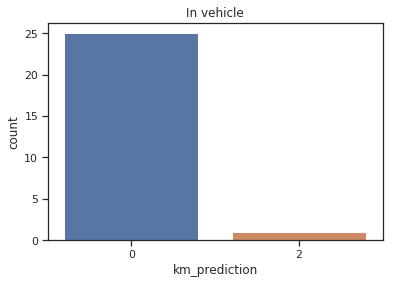

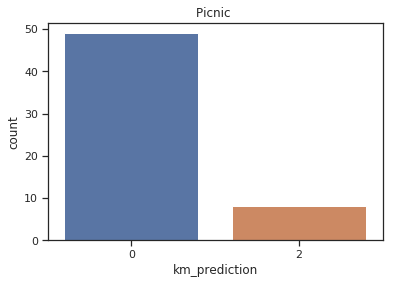

In [54]:
y = pd.DataFrame(y)
y['km_prediction']=km_labels
for activity_type in y['activity_type'].unique():
    data = y[y['activity_type'] == activity_type]
    plt.show()
    sns.countplot(x="km_prediction", data=data).set_title(activity_type)

In [161]:
# list(y['activity_type'].unique())

### 5. Classification

#### Sans l'ACP:

In [58]:
# activites_mobiles = ['Walk','Cooking', 'Football']
# labels = []
# for activity_type in list(y['activity_type']):
#     if activity_type in activites_mobiles:
#         labels.append(1)
#     else:
#         labels.append(0)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y['activity_type'], test_size=0.2, random_state=101)

In [74]:
names = [
    "Nearest Neighbors",
    "Decision Tree", 
]

classifiers = [
    KNeighborsClassifier(1),
    DecisionTreeClassifier(max_depth=5),
    ]

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))
    scores = cross_validate(clf, X, labels, cv=3)['test_score']
    print(name + ' cross-validated scores: ')
    print(scores)
    print("\n")
    



Nearest Neighbors score: 0.54
Nearest Neighbors cross-validated scores: 
[0.8313253  0.8313253  0.75609756]




Decision Tree score: 0.44
Decision Tree cross-validated scores: 
[0.86746988 0.73493976 0.7804878 ]




#### Avec l'ACP:

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y['activity_type'], test_size=0.3, random_state=101)

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))
    scores = cross_validate(clf, X, labels, cv=3, return_train_score=True)['test_score']
    print(name + ' cross-validated scores: ')
    print(scores)
    print("\n")
    



Nearest Neighbors score: 0.55
Nearest Neighbors cross-validated scores: 
[0.8313253  0.8313253  0.75609756]




Decision Tree score: 0.49
Decision Tree cross-validated scores: 
[0.86746988 0.74698795 0.74390244]


